In [1]:
import numpy as np
from imports import *
plt.set_cmap('inferno')

<Figure size 640x480 with 0 Axes>

In [86]:

#Specify the shape of the images, the number of images in the sequence and load the image sequence using the gen_seq_function
nx= 64
ny = nx
shape = (nx,ny)
size = nx*ny
t_end = 2

v_max = 1
v_min = 1
padding = 2
data = gen_im_seq(shape,t_end,v_max=v_max,v_min=v_min, padding =padding)
u_traj = data.u_traj
u_inv_traj = data.u_inv_traj
v_primes=data.v_primes
vs=data.vs

t_0 = 15
u_traj_ = np.load('mnist_test_seq.npy')[:,0,:,:][t_0:t_0+t_end]#*10
u_traj = [vec(u) for u in u_traj_]
u_inv_traj=u_traj[::-1]


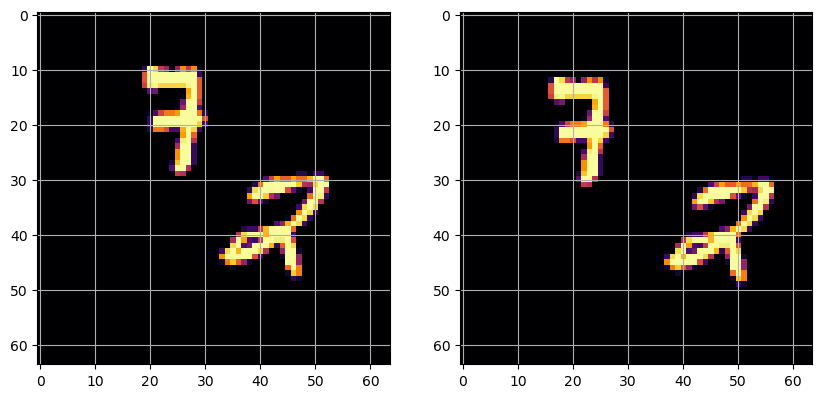

In [87]:
fig,ax=plt.subplots(1,t_end,figsize=(10,5))
for i in range(0,t_end):
    ax[i].imshow(u_traj[i].reshape(shape))
    ax[i].grid('minor')

In [47]:
spread = [1,1]
dim = (3,3)
noise_level = 1e-2
x_traj =u_traj # [u*10 for u in u_traj]# [vec(u) for u in u_traj]

X_true, A_bar,data_vec_bar,data_vec_true_bar,L_bar, I_bar,deltas = gen_joint_blur_op_and_data2(x_traj, t_end, nx,ny, spread,dim,noise_level=noise_level)
b_size = shape[0]*shape[1]

delta = np.mean(deltas) #la.norm(data_vec_true_bar-data_vec_bar) #/#la.norm(data_vec_true_bar)
print(delta)

data already in the path.
data already in the path.
0.09922030722857182


<Figure size 640x480 with 0 Axes>

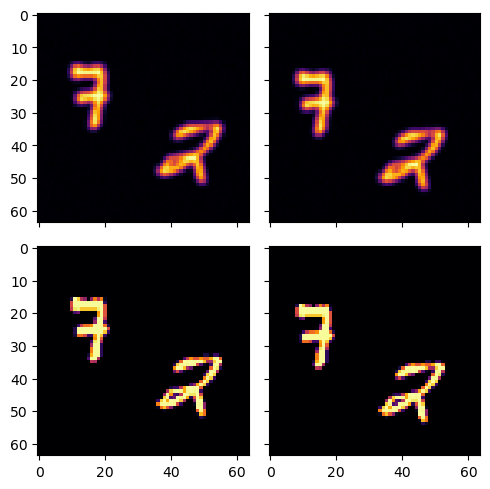

In [48]:
plt.set_cmap('inferno')
fig,ax=plt.subplots(2,t_end,sharex=True, sharey=True,figsize=(5,5))
data_vec_bar_list_c = [data_vec_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
data_vec_true_bar_list_c = [data_vec_true_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
x_true_list = [X_true[b_size*i:b_size*(i+1)] for i in range(t_end)]
for i in range(0,t_end):
    ax[0,i].imshow(data_vec_bar_list_c[i].reshape(shape),aspect='auto')
    ax[1, i].imshow(x_true_list[i].reshape(shape),aspect='auto')
plt.tight_layout()

In [6]:
delta_=la.norm(data_vec_bar-data_vec_true_bar)
delta_

0.14035569981473064

In [49]:
#Number of iterations for the optical flow solution


n_iter = 20
n_iter_b = 60
proj_dim = 10
vs_true = None# vs 
v_primes_true= None#v_primes 
reduction = True
scale = 1
epsilon=1e-1
non_neg = False
v_max = 3
delta = 0.1

# MMGKS

from imports import *
from trips.solvers.MMGKS import *
# (X_mmgks_, info_mmgks_) = MMGKS(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
#                         n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,delta=delta)
# error_mmgks_ = info_mmgks_['relError'][-1]
# X_mmgks_list_ = [X_mmgks_[size*i:size*(i+1)] for i in range(t_end)]
# print(error_mmgks_)


# (X_mmgks_2, info_mmgks_2) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
#                         n_iter =n_iter, regparam = 'gcv', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
# error_mmgks_2 = info_mmgks_2['relError'][-1]
# X_mmgks_list_2 = [X_mmgks_2[size*i:size*(i+1)] for i in range(t_end)]
# print(error_mmgks_2)
# ##MMGKS

(X_mmgks, info_mmgks) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
error_mmgks = info_mmgks['relError'][-1]

X_mmgks[X_mmgks<0]=0
X_mmgks_list = [X_mmgks[size*i:size*(i+1)] for i in range(t_end)]

print('MMGKS Solution relative error:', error_mmgks)

#ISO-TV
nt = t_end
L = gen_spacetime_derivative_operator(nx, ny, nt)
from trips.solvers.MMGKS import *
# Use GKS to compute an approximate solution
(X_TV_iso, info_TV_iso) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
                                regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, isoTV = 'isoTV', prob_dims = (nx,ny, nt),delta=delta)
error_TV_iso = info_TV_iso['relError'][-1]
X_TV_iso[X_TV_iso<0]=0
X_TV_iso_list = [X_TV_iso[size*i:size*(i+1)] for i in range(t_end)]
print('TV iso Solution relative error:', error_TV_iso)

## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'dp',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta,pnorm_opt=1, qnorm_opt=1,non_neg=non_neg,interval = 10)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...: 100%|██████████| 20/20 [00:00<00:00, 44.05it/s]


MMGKS Solution relative error: 0.06988373869986841


running MMGKS...: 100%|██████████| 20/20 [00:00<00:00, 29.78it/s]


TV iso Solution relative error: 0.12270761676596668


running MMGKS...:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\okuno\anaconda3\Lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
running MMGKS...: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Dynamic MMGKS Solution relative error: 0.08159634816076268


In [94]:
(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =40, n_iter_b = 80, regparam = 'dp', regparam_dyn = 'dp',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=3, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=1,epsilon=epsilon,delta =delta,pnorm_opt=2, qnorm_opt=1,non_neg=non_neg,interval = 10)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)

running MMGKS...: 100%|██████████| 40/40 [01:36<00:00,  2.41s/it]

Dynamic MMGKS Solution relative error: 0.08922469006230077


In [ ]:
(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =40, n_iter_b = 80, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=3, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=1,epsilon=epsilon,delta =delta,pnorm_opt=1, qnorm_opt=1,non_neg=non_neg,interval = 10)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)

running MMGKS...: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it]

Dynamic MMGKS Solution relative error: 0.08364555941504043


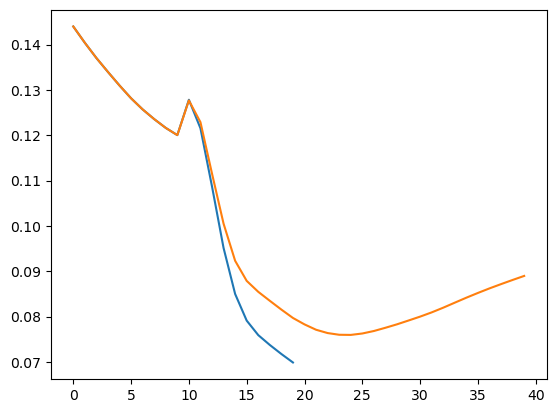

In [83]:
error_mmgks_2 = info_mmgks_dyn['relError']
error_mmgks = info_mmgks['relError']

plt.plot(error_mmgks)
plt.plot(error_mmgks_2)


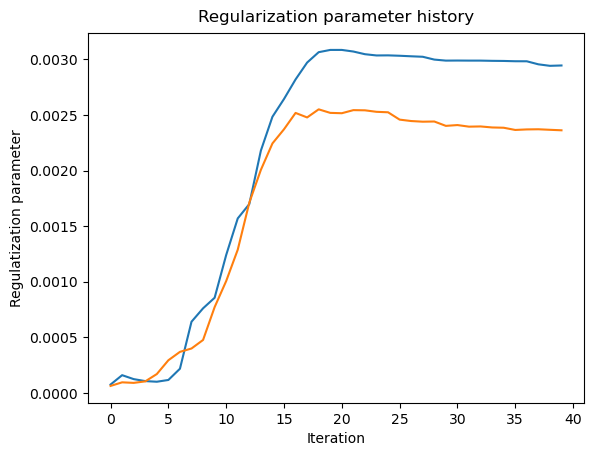

In [55]:
reg_param_mmgks = info_mmgks['regParam_history'][:]
reg_param_mmgks_dyn = info_mmgks_dyn['regParam_history'][:100]

plt.plot(reg_param_mmgks)
plt.plot(reg_param_mmgks_dyn)
plt.xlabel('Iteration') 
plt.ylabel('Regulatization parameter')
plt.title('Regularization parameter history',va='bottom');

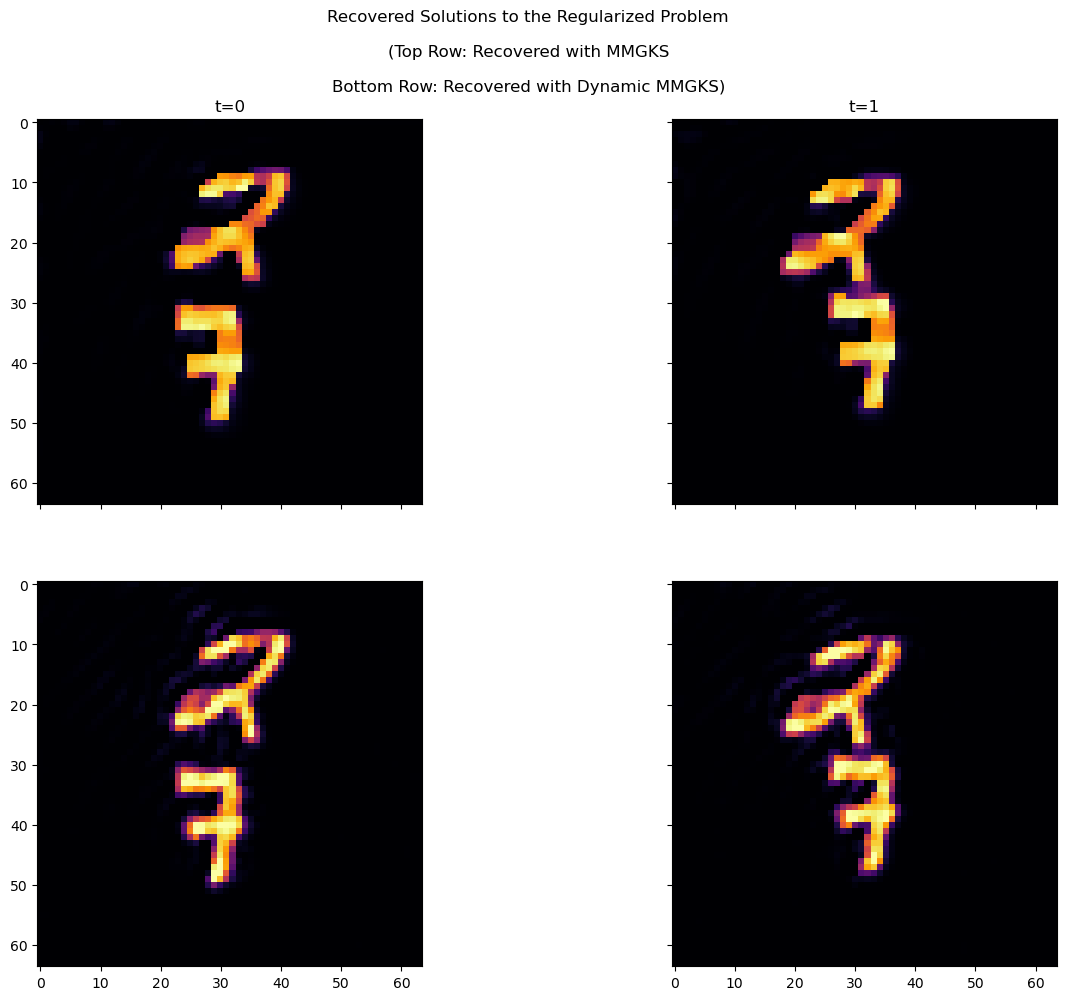

In [13]:
fig,ax=plt.subplots(2,t_end,figsize=(15,11),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape),vmin=X_true.min(),vmax=X_true.max())
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape),vmin=X_true.min(),vmax=X_true.max())

    ax[0,i].set_title(f't={i}')
plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

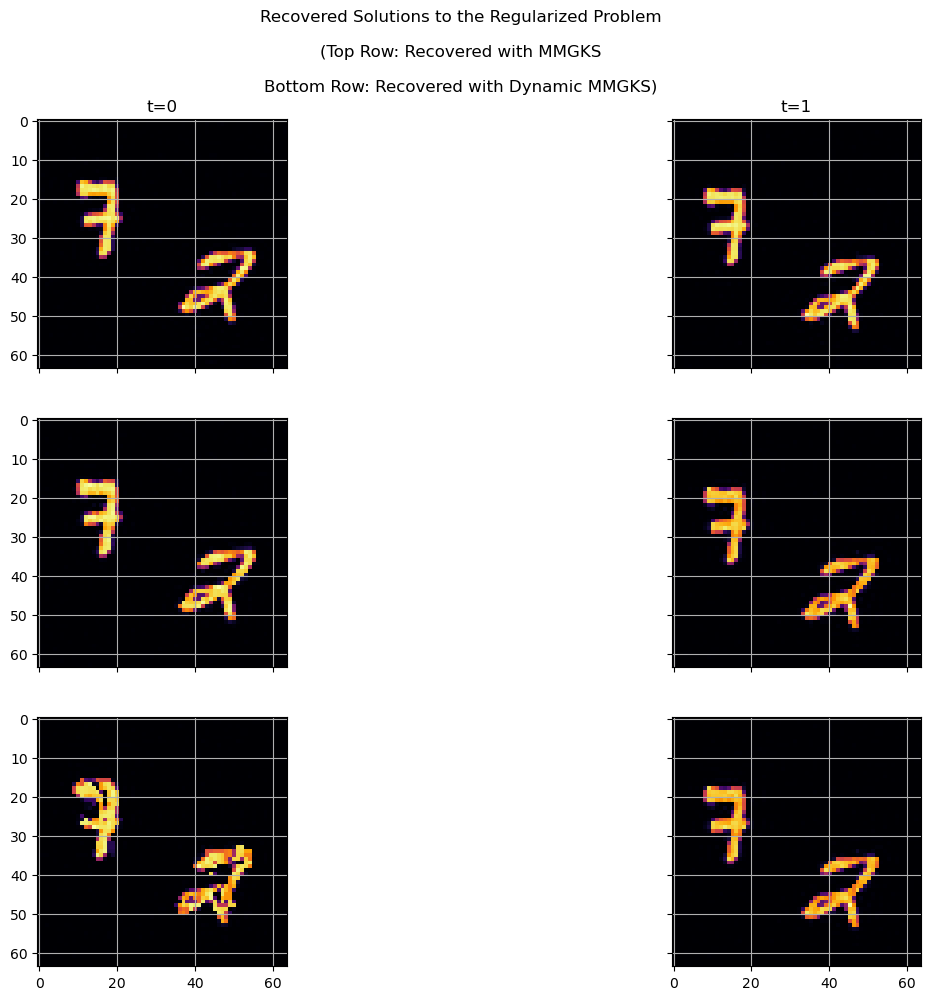

In [95]:
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
fig,ax=plt.subplots(3,t_end,figsize=(15,11),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[2,i].imshow(rec_list[i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    ax[2,i].grid('minor')

plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

In [96]:
nt = 2
RRE_opt = [rre(rec_list[i].reshape(nx,ny), X_mmgks_dyn.reshape(nt,nx,ny)[i]) for i in range(nt)]
RRE_opt,np.mean(RRE_opt[:nt-1])

([0.6670061701435573, 0.0], 0.6670061701435573)

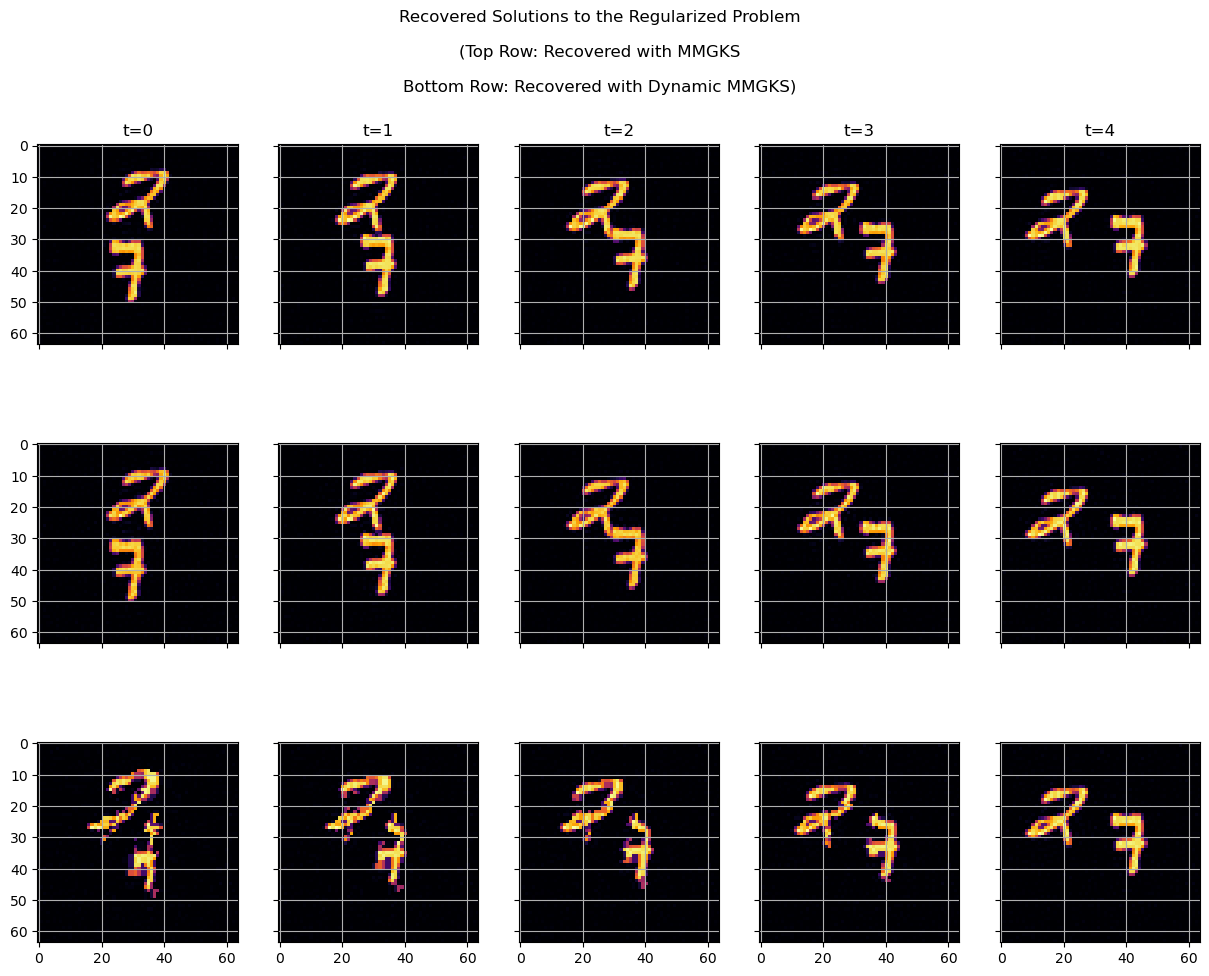

In [229]:
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@rec_list[-1]
    rec_list.append(next_)
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
#     rec_list.append(next_)
fig,ax=plt.subplots(3,t_end,figsize=(15,11),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[2,i].imshow(rec_list[::-1][i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    ax[2,i].grid('minor')

plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

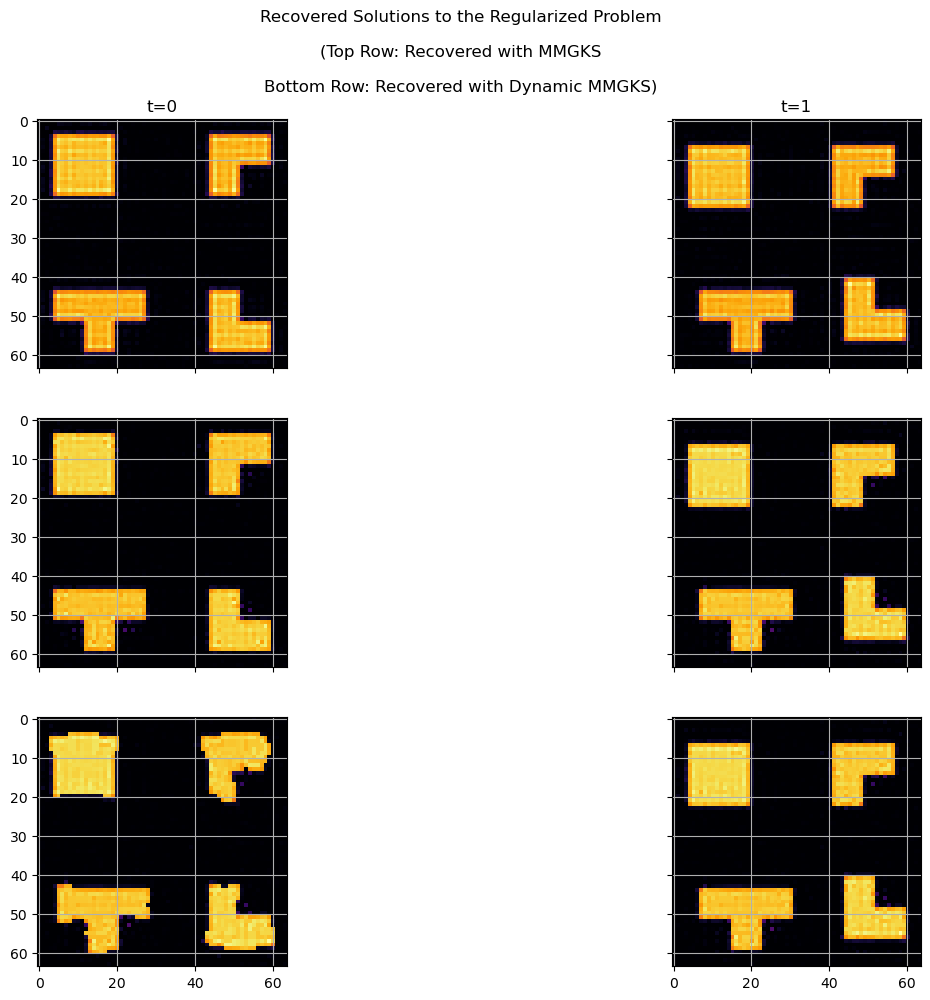

In [87]:
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@rec_list[-1]
    rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
fig,ax=plt.subplots(3,t_end,figsize=(15,11),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[2,i].imshow(rec_list[::-1][i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    ax[2,i].grid('minor')

plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

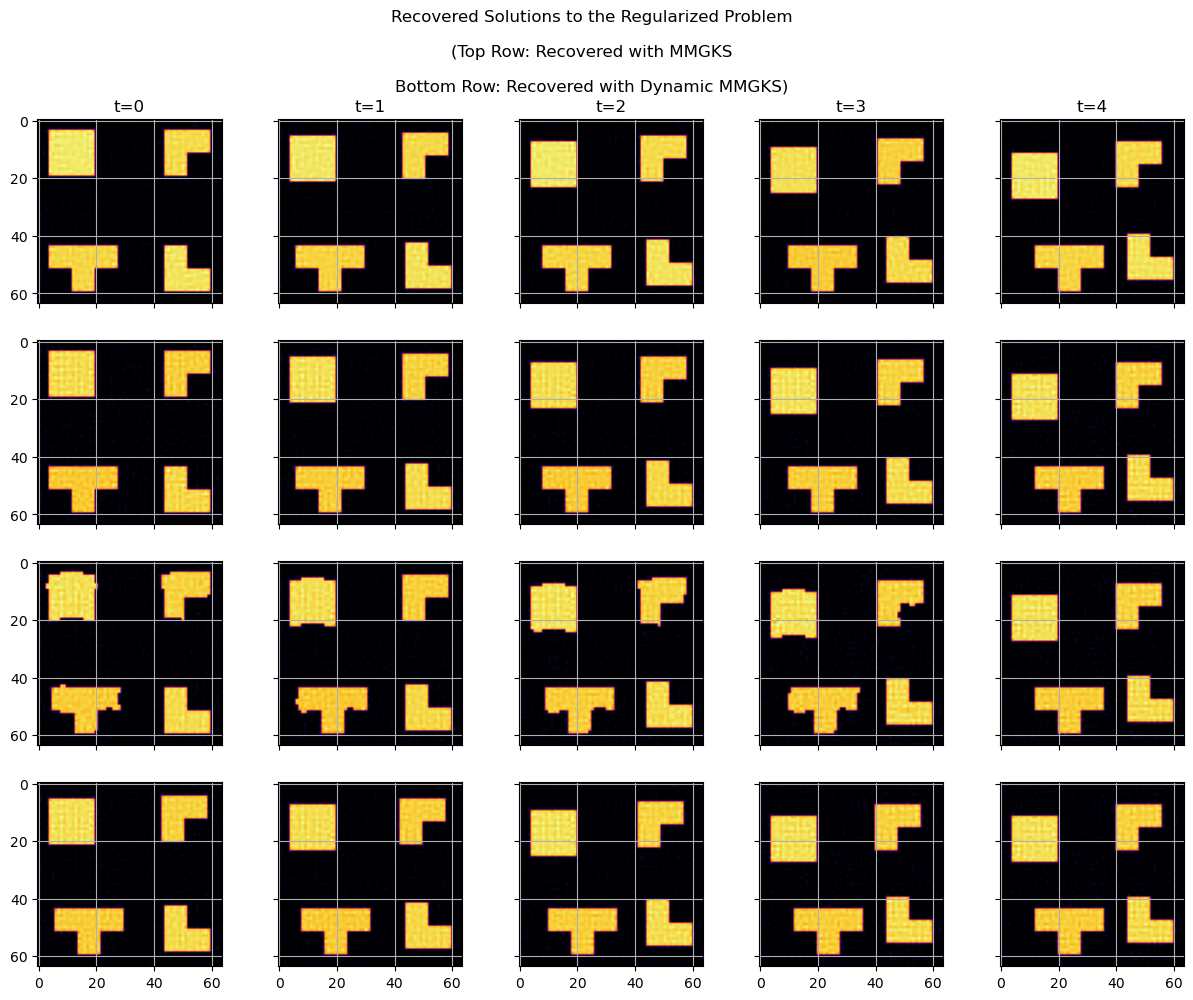

In [244]:
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list_ = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list_.append(next_)
fig,ax=plt.subplots(4,t_end,figsize=(15,11),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[2,i].imshow(rec_list[::-1][i].reshape(shape))
    ax[3,i].imshow(rec_list_[::-1][i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    ax[2,i].grid('minor')
    ax[3,i].grid('minor')

plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

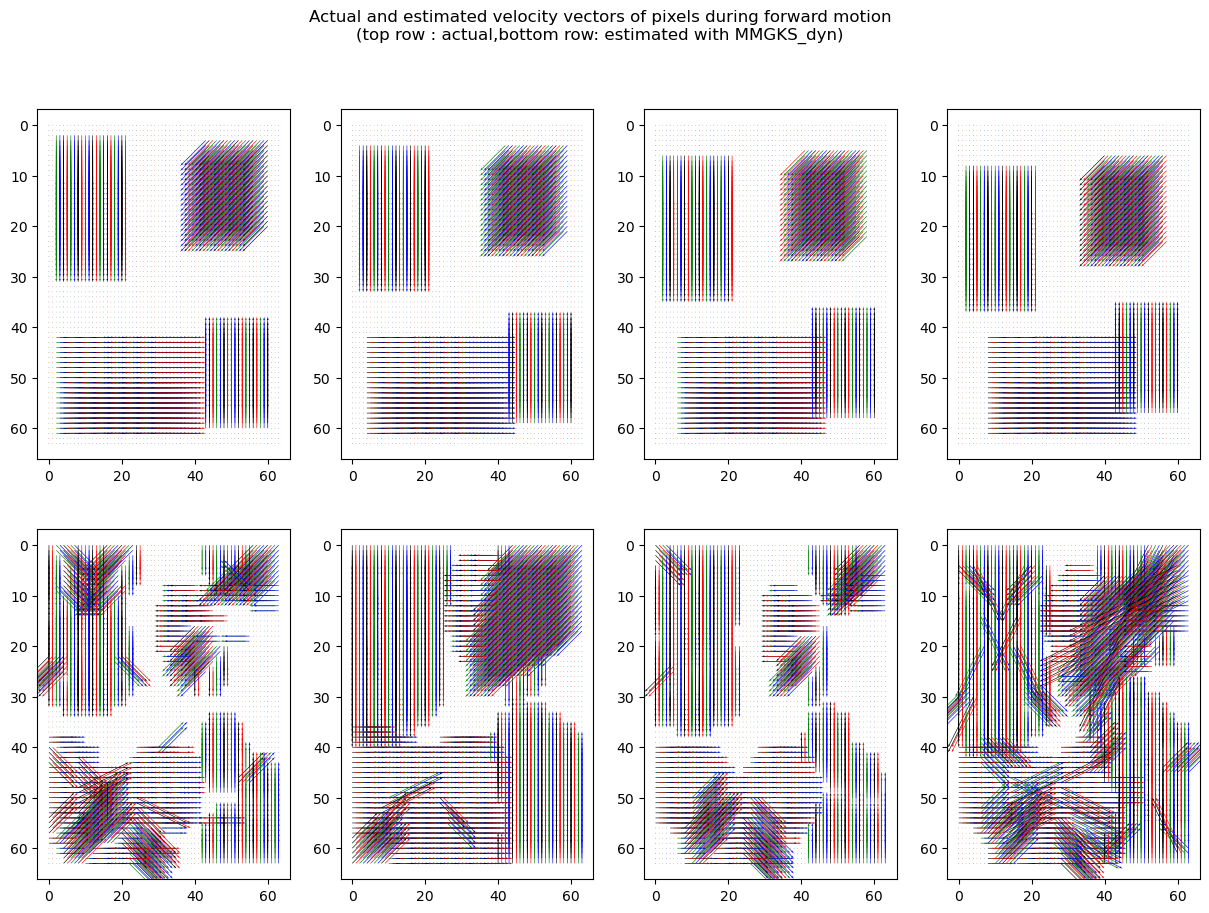

In [246]:
real_0= vs[0].reshape((nx*ny,2))


est_0= vs_est[0].reshape((nx*ny,2))
R = np.array(list(np.ndindex(*shape)))
origin = [np.array(R)[:,1], np.array(R)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(15,10))
if (t_end<=2):
    ax = ax.reshape((-1,1))
for i in range(t_end-1):
    real_0= vs[i].reshape((nx*ny,2))
    est_0= np.rint(vs_est[i]).reshape((nx*ny,2))
    ax[0,i].quiver(*origin, real_0[:, 1], -real_0[:, 0], color=['black', 'red', 'green','blue'],scale=10)
    ax[0,i].invert_yaxis()

    ax[1,i].quiver(*origin, est_0[:, 1], -est_0[:, 0], color=['black', 'red', 'green','blue'],scale=10)
    ax[1,i].invert_yaxis()

fig.suptitle('Actual and estimated velocity vectors of pixels during forward motion' + '\n' + '(top row : actual,'+ 
             'bottom row: estimated with MMGKS_dyn)');
plt.show()



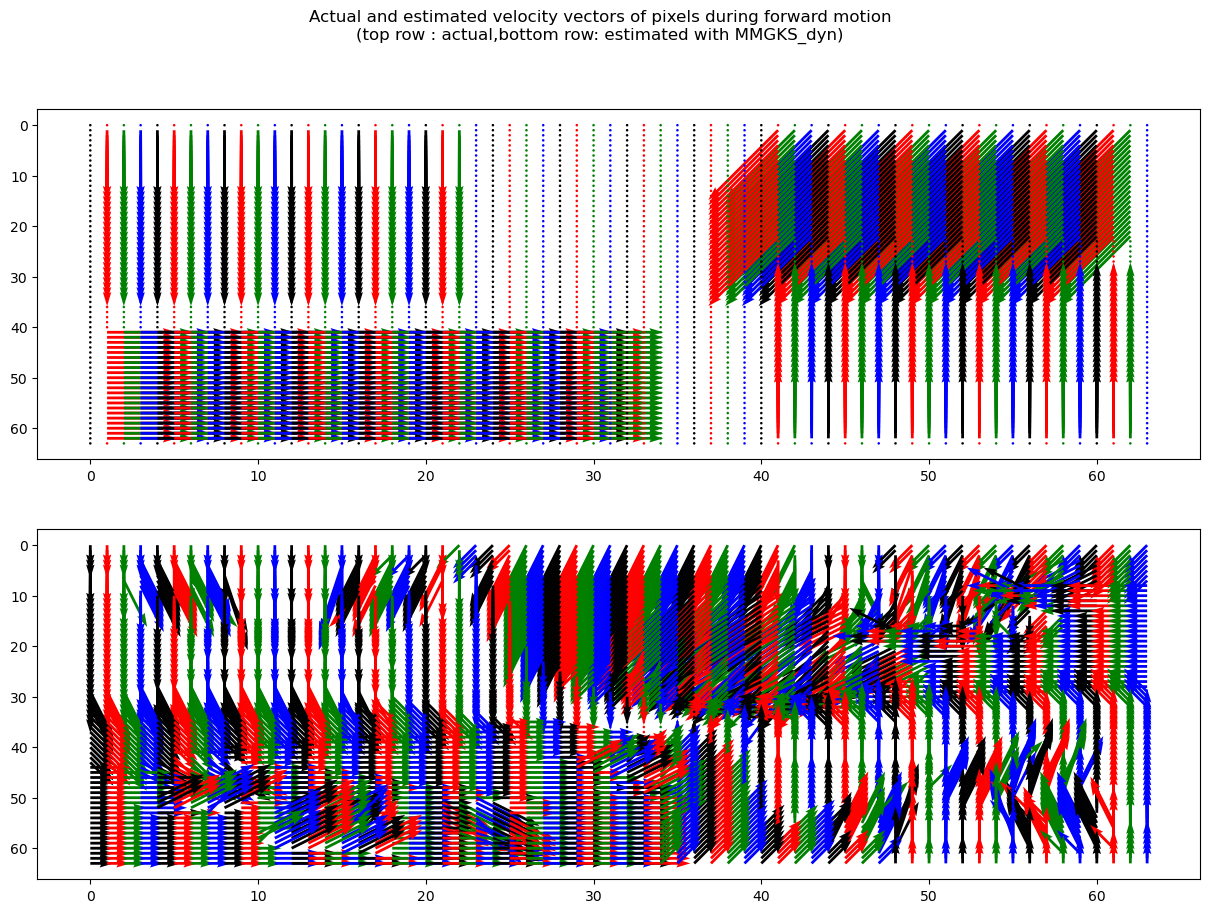

In [88]:
real_0= vs[0].reshape((nx*ny,2))


est_0= vs_est[0].reshape((nx*ny,2))
R = np.array(list(np.ndindex(*shape)))
origin = [np.array(R)[:,1], np.array(R)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(15,10))
if (t_end<=2):
    ax = ax.reshape((-1,1))
for i in range(t_end-1):
    real_0= vs[i].reshape((nx*ny,2))
    est_0= np.rint(vs_est[i]).reshape((nx*ny,2))
    ax[0,i].quiver(*origin, real_0[:, 1], -real_0[:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()

    ax[1,i].quiver(*origin, est_0[:, 1], -est_0[:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[1,i].invert_yaxis()

fig.suptitle('Actual and estimated velocity vectors of pixels during forward motion' + '\n' + '(top row : actual,'+ 
             'bottom row: estimated with MMGKS_dyn)');
plt.show()



In [13]:
def vec2(img):
    if len(img.shape)==2:
        vector = img.reshape(img.shape[0]*img.shape[1])
    else:
        vector=img
    return vector
def mu(x):
    return np.mean(vec2(x))
def sigma(x):
    return np.std(vec2(x),ddof=1)
def ssigma(x,y):
    x= vec(x)
    y=vec(y)
    N=len(x)
    return (1/(N-1))*np.sum((x-mu(x))*(y-mu(y)))
def l(x,y):
    return 2*mu(x)*mu(y)/(mu(x)**2  + mu(y)**2)  
def c(x,y):
    return 2*sigma(x)*sigma(y)/(sigma(x)**2  + sigma(y)**2)  
def s(x,y):
    return ssigma(x,y)/(sigma(x)*sigma(y))
def ssim(x,y,alpha=1,beta=1,gamma=1):
    return l(x,y)**alpha * c(x,y)**beta * s(x,y)**gamma
def ssim_all(X,Y,nt,nx,ny,alpha=1,beta=1,gamma=1):
    X = np.array(X).reshape(nt,nx,ny)
    Y = np.array(Y).reshape(nt,nx,ny)
    return np.mean([ssim(X[i],Y[i],alpha,beta,gamma) for i in range (nt)])
def rre(x,x_true):
    return la.norm(x-x_true)/la.norm(x_true)
def rre_all(X,X_true,nt,nx,ny):
    X = np.array(X).reshape(nt,nx,ny)
    X_true = np.array(X_true).reshape(nt,nx,ny)
    return np.mean([rre(X[i],X_true[i]) for i in range (nt)])